# Biosignals Processing

## Import Data

In [26]:
# Import packages
import neurokit as nk
import pandas as pd
import numpy as np
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]  # Bigger figures

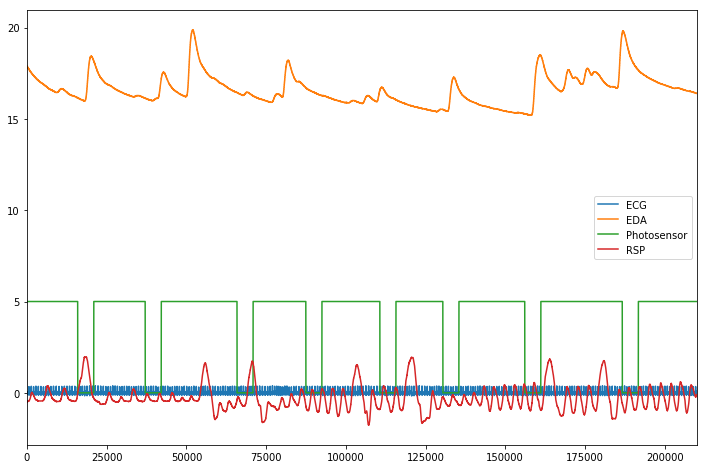

In [27]:
df = pd.read_csv("data_bio.csv")
df.plot()

df contains 3.5 minutes of data recorded at 1000Hz. There are 4 channels, EDA, ECG, RSP and the Photosensor used to localize events.

## Process it

In [31]:
bio_features = nk.process_bio(ecg=df["ECG"], rsp=df["RSP"], eda=df["EDA"])
bio_features.keys()  # See what it contains

dict_keys(['SCR_Onsets', 'EDA_Phasic', 'ECG_Filtered', 'EDA_Filtered', 'ECG_Raw', 'SCR_Peaks_Amplitudes', 'HRV', 'Heart_Beats', 'RSP_Raw', 'EDA_Raw', 'ECG_Rpeaks_Indexes', 'SCR_Peaks_Indexes', 'RSP_Filtered', 'Heart_Rate'])

## ECG Miscellaenous

### Heart Beats

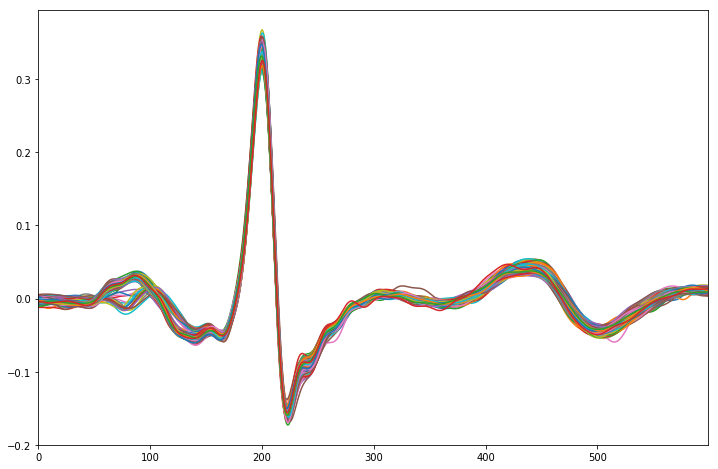

In [28]:
pd.DataFrame(bio_features["Heart_Beats"]).T.plot(legend=False)  # Plot all the heart beats

This plot contains all 274 detected heart beats synchronized by their R peak.

### Heart Rate Variability (HRV)

In [30]:
# Print all the HRV indices
print(bio_features["HRV"])

{'lf': 1681.79, 'pnn50': 4.7800000000000002, 'total_power': 2280.6799999999998, 'lfnu': 87.730000000000004, 'rmssd': 24.699999999999999, 'mhr': 78.969999999999999, 'mrri': 763.14999999999998, 'lf_hf': 7.1500000000000004, 'sdnn': 50.920000000000002, 'hfnu': 12.27, 'hf': 235.12, 'vlf': 363.76999999999998, 'nn50': 13.0}


In [ ]:
## Add Processed Signals  to Data Frame

df["ECG_Filtered"] = bio_features["ECG_Filtered"]
df["Heart_Rate"] = bio_features["Heart_Rate"]
df["RSP_Filtered"] = bio_features["RSP_Filtered"]
df["ECG_Filtered"] = bio_features["ECG_Filtered"]
df["ECG_Filtered"] = bio_features["ECG_Filtered"]
df["ECG_Filtered"] = bio_features["ECG_Filtered"]